# Load packages

In [60]:
import scipy.io
import os
import pickle

# Define functions to convert matlab data objects into pandas DataFrames

In [8]:
import pandas as pd
import numpy as np

def mat2DF(mat):

    # convert the matlab object entries to arrays
    [t, tVR, tFrameGrab, OffsetRot, OffsetFor, OffsetLat] = getArrayFromMatObj(mat)
    
    # get imaging parameters
    [num_planes, minFG, maxFG] = getImParams(t,tVR,tFrameGrab,mat)
    
    # Match the position data to the framegrab times
    OffsetRotMatch = np.zeros((maxFG-minFG+1,2))
    OffsetForMatch = np.zeros(maxFG-minFG+1)
    OffsetLatMatch = np.zeros(maxFG-minFG+1)
    for interp in range(minFG,maxFG):
        tMatch = np.where(t >= (t[0] + (tFrameGrab[(interp-1)*num_planes]-tVR[0])/10000))[0]
        OffsetRotMatch[interp-minFG,0] = t[tMatch[0]]
        OffsetRotMatch[interp-minFG,1] = np.pi/180*OffsetRot[tMatch[0]]
        OffsetForMatch[interp-minFG] = OffsetFor[tMatch[0]]
        OffsetLatMatch[interp-minFG] = OffsetLat[tMatch[0]]

    DF = pd.DataFrame({'t':OffsetRotMatch[:,0],
                       'angle':OffsetRotMatch[:,1],
                       'forward position':OffsetForMatch,
                       'lateral position':OffsetLatMatch})
    for r in range(mat['GROIaveMax'].shape[0]):
        DF['roi ' + str(r) + ' Green'] = mat['GROIaveMax'][r,minFG-1:maxFG]
    for r in range(mat['RROIaveMax'].shape[0]):
        DF['roi ' + str(r) + ' Red'] = mat['RROIaveMax'][r,minFG-1:maxFG]

    return DF

def getArrayFromMatObj(mat):
    t = [a[0] for a in mat['positionDat']['t'][0][0]]
    tVR = mat['positionDat']['tVR'][0][0][0]
    tFrameGrab = mat['positionDat']['tFrameGrab'][0][0][0]  
    OffsetRot = [a[0] for a in mat['positionDat']['OffsetRot'][0][0]]
    OffsetFor = [a[0] for a in mat['positionDat']['OffsetFor'][0][0]]
    OffsetLat = [a[0] for a in mat['positionDat']['OffsetLat'][0][0]]

    return [t, tVR, tFrameGrab, OffsetRot, OffsetFor, OffsetLat]

def getImParams(t,tVR,tFrameGrab,mat):
    num_planes = int(len(tFrameGrab)/mat['GROIaveMax'].shape[1])
    minFG = int(np.ceil(np.min(np.where(tFrameGrab >= tVR[0]))/num_planes))
    maxFG = int(np.round(len(tFrameGrab)/num_planes))

    return [num_planes, minFG, maxFG]

# Load data into a dictionary of pandas notebooks and save

In [56]:
parent_dirs = ['PEN1-EB','PEN1-PB']
allDat = {}
for d in parent_dirs:
    dates = [dt for dt in os.listdir(os.path.join('./data',d)) if not dt.startswith('.')]
    flyID = 0
    allDat[d] = {}
    for dt in dates:
        files = os.listdir(os.path.join('./data',d,dt))
        files.sort()
        flyNm = ''
        for f in files:            
            mat = scipy.io.loadmat(os.path.join('./data',d,dt,f))
            DF = mat2DF(mat)

            nm = f.split('_')[0]
            if nm != flyNm:
                flyNm = nm
                flyID += 1
                fly = 'Fly ' + str(flyID)
                allDat[d][fly] = {}
                allDat[d][fly]['date'] = dt
                allDat[d][fly]['age'] = f.split('_')[1]
                allDat[d][fly]['colors'] = f.split('_')[2:4]
                allDat[d][fly]['Dark'] = {}
                allDat[d][fly]['1x'] = {}
                allDat[d][fly]['2x'] = {}
       
            trial = 'Trial ' + str(f[-5])
            gain = f.split('_')[-2]
            allDat[d][fly][gain][trial] = DF

Fly1
Fly2
Fly1
Fly1
Fly2
Fly3
Fly2
Fly1
Fly2
Fly3
Fly1
Fly2
Fly1
Fly2
Fly3
Fly4
Fly5
Fly1
Fly2
Fly1
Fly3
Fly4
Fly5
Fly6
Fly1
Fly2
Fly4
Fly1
Fly2
Fly3
Fly4
Fly1
Fly2


In [61]:
output = open('./data/PEN1data.pkl', 'wb')
pickle.dump(allDat, output)
output.close()

In [62]:
input = open('./data/PEN1data.pkl', 'rb')
allDF = pickle.load(input)
input.close()

(array([5.000e-01, 2.150e+01, 4.250e+01, 6.350e+01, 8.450e+01, 1.055e+02,
        1.265e+02, 1.475e+02, 1.685e+02, 1.895e+02, 2.105e+02, 2.315e+02,
        2.525e+02, 2.735e+02, 2.945e+02, 3.155e+02, 3.365e+02, 3.575e+02,
        3.785e+02, 3.995e+02, 4.205e+02, 4.415e+02, 4.625e+02, 4.835e+02,
        5.045e+02, 5.255e+02, 5.465e+02, 5.675e+02, 5.885e+02, 6.095e+02,
        6.305e+02, 6.515e+02, 6.725e+02, 6.935e+02, 7.145e+02]),
 [Text(0.5, 0, '3.075731'),
  Text(21.5, 0, '4.914415'),
  Text(42.5, 0, '6.756136'),
  Text(63.5, 0, '8.597761'),
  Text(84.5, 0, '10.430838'),
  Text(105.5, 0, '12.272437'),
  Text(126.5, 0, '14.105835'),
  Text(147.5, 0, '15.947285'),
  Text(168.5, 0, '17.789007'),
  Text(189.5, 0, '19.62225'),
  Text(210.5, 0, '21.463829'),
  Text(231.5, 0, '23.305447'),
  Text(252.5, 0, '25.138687'),
  Text(273.5, 0, '26.98031'),
  Text(294.5, 0, '28.82177'),
  Text(315.5, 0, '30.655029'),
  Text(336.5, 0, '32.496616'),
  Text(357.5, 0, '34.338161'),
  Text(378.5, 0, '36

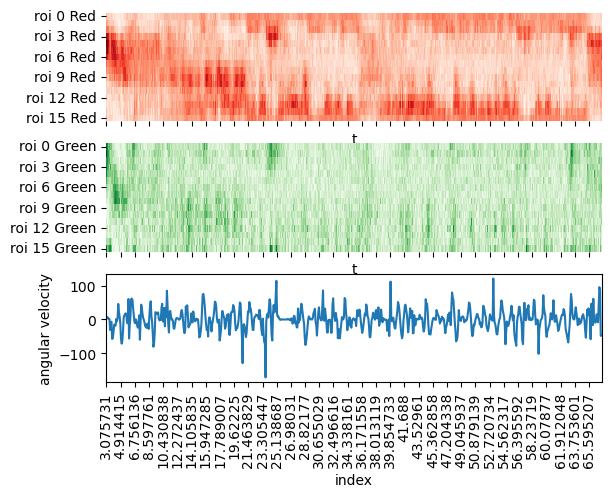

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

DF = allDat['PEN1-EB']['Fly 6']['1x']['Trial 5']

GROIs = [g for g in DF.columns if 'Green' in g]
RROIs = [r for r in DF.columns if 'Red' in r]

angVel = np.diff(DF['angle'])/np.mean(np.diff(DF['t']))
DF['angular velocity'] = np.append(angVel,angVel[-1])
DF = DF.reset_index()

fig, axs = plt.subplots(nrows = 3, sharex = True)
sns.heatmap(DF[['t'] + RROIs].set_index('t').T,
            cmap = 'Reds', ax = axs[0], cbar = False)
sns.heatmap(DF[['t'] + GROIs].set_index('t').T,
            cmap = 'Greens', ax = axs[1], cbar = False)
sns.lineplot(data = DF, x = 'index', y = 'angular velocity')
plt.xticks(rotation=90)